# SMRT tutorial for ECCC


***
##### by Julien Meloche 



# Snow Microwave Radiative Tranfer (SMRT) model





Amazing work from Ghislain Picard, Melody Sandells and Henning Löwe!

- Build on previous knowledge on radiative transfer modelling (DMRT and MEMLS)
- Allows for intercomparison of different model elements: electromagnetic theory, microstructure, ice permittivity and much more!
- Modularity (we keep adding more stuff!)
- Written in Python

At ECCC

We will mainly use it to estimate backscatter from snow properties.

## Simply put
### SMRT allows you to simulate measurements of radar or radiometer from snow and or ice properties.

<img src = "assets/SWE_retrieval_SMRT.png" width =900>


***
<br>

![a](assets/SWE_retrieval_SMRT.png)

#### Radar and Snow!

$ \sigma_{tot}^{pq} =  \sigma_{vol}^{pq} + \sigma_{bg}^{pq} +\sigma_{interface}^{pq}$

for a particular polarisation state (pq)

<img src="assets/backscatter_interaction_Tsangetal2022.png">

<br><br>
Tsang et al 2022 doi :  https://doi.org/10.5194/tc-16-3531-2022


- Snow generates volume scattering from snow grains. Snow is represented as a medium of ice/air (microstructure).
- The background also generates a strong return in backscatter. We need to account for it by estimating the soil permittivity and roughness.
- Backscatter from the reflection of interface is minimal. It is the strongest at the air-snow layer because of the permittivity change ($\varepsilon_{snow} \approx  1.6$)

<br>
wise word for Ghislain Picard (SMRT git hub page)

- Backscatter of a snowpack with flat surface is only due to the grains/ice nodules (assuming no underlying soil or rough ice). A rough surface has usually little impact for dry snowpack because the permittivity of light snow is not large (~1.6).
- Adding water near the surface increases (a lot) the absorption, so the wave penetrates less -> less scattering -> less backscatter. If snow get wet, not only the absorption increases, but also the refractive index (see Fig 1 https://doi.org/10.5194/tc-2022-85). Backscatter from the surface increases as a function of the liquid water content of the superficial layers (say a few centimeters). This is what is observed for soil.

***
#### Polarisations

for a particular polarisation state (pq) (e.g $\sigma_{vol}^{VH}$, emmited = vertical, received = horizontal)

##### Co-polarisation
- VV : vertical polarisations - sensitive to vertical structure or bulk properties of the snowpack
- HH : Horizontal polarisations - sensitive to horizontal structure like ice lense and layering.

##### Cross-polarisation (X-pol)
- VH or HV: when emmitted differs from the received polarisations - sensitive to depolarisation of the waves (volume scattering and snow anisotropy)

#### TSMM will use VV and VH pol

***

### SMRT use the DORT solver yo solve the radiative transfer equation (RTE) through all layers

#### RTE:
$ \large \mu \frac{\partial \mathbf{I}(\mu,\phi,z)}{\partial_z} = -\kappa_e(\mu,\phi,z)\mathbf{I}(\mu,\phi,z)+ \frac{1}{4\pi} \iint_{4\pi}P(\mu,\phi;\mu',\phi',z)\mathbf{I}(\mu',\phi',z)d\Omega'+\kappa_a(\mu,\phi,z)\alpha T(z)1$
<br><br>
<br>
<img src="assets/Multilayered-medium_SMRT.jpg">
<br>

### Final output is $T_B$ or $\sigma^0$ with polarisation H and V
***

### Snowpack Data or inputs

- Multi layered snowpack (density, temperature, ...)


<img src="assets/SMRT.png" width = 700>


### Electromagnetic model
#### Yields ka, ks and effective permittivity for EM theory and microstructure model.


- Dense Media Radiative Transfer (DMRT) : for example, using DMRT, represents the microstructure as aggregates of ice spheres in air are represented in each snow layers using the equivalent diameter = $D_{0}$  and stickiness ($\tau$).
<br><br>
$ \large D_{0} = \frac{6}{SSA \rho_i} $
<br><br>
- Improved Born Approximation (IBA) : represents snow layer in a random two phase ice/air medium. 
- ACF of the medium can be assumed to be exponential but you don't have to! Numerous microstructure (or ACF) can be used with IBA, even dense media. 
- One easy way would be to define the correlation length (porod length) of the snow microstructure with the debye equation using the snow density $\rho_s$ and the SSA.
<br><br>
$ \large l_c = \kappa \frac{4(1-\phi_i)}{\rho_i SSA} $
<br><br>
where the volume fraction is define as such $ \phi_i = \rho_s/\rho_i$.
<br><br>
Sometimes, an empirical factor ($\kappa$) called the debye factor is used to adjust the scattering depending on frequency and region but we should avoid this in the future!!
<br><br>
check this great article https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021AV000630

#### Polydispersity 
We redefine $l_c$ --> $l_{MW}$  <br><br>
$l_{MW}$ = $K_{medium}$ × $l_{(p,medium)}$ <br><br>

The goal would be to provide polydispersity from grain type

***

For this tutorial <br>
We will use IBA with exponential microstructure and polydispersity = 1

***

#### Even with all this complexity, SMRT can be easy and simple to use.

In [1]:
from smrt import make_snowpack, make_model, sensor_list
from smrt.utils import dB

import warnings
warnings.filterwarnings('ignore')

#prepare inputs in SI
thick = [100] #m
corr_length = [8e-5] # 80 microns
temperature = [270] # kelvin
density = [320] #kg/m^3

#create the snowpack
snowpack = make_snowpack(thickness = thick,
                         microstructure_model = "exponential",
                         density = density,
                         temperature = temperature,
                         corr_length = corr_length)

#create the sensor
#set frequency to 17.25 GHz and incident angle to 35
radar = sensor_list.active(17.25e9, 35)

#create the model
m = make_model("iba", "dort")

#run the model
result = m.run(radar, snowpack)

#outputs
print(f' sig VV = {result.sigmaVV()}, sig HH = {result.sigmaHH()}')
print(f' sig VV = {dB(result.sigmaVV())}, sig HH = {dB(result.sigmaHH())}')

 sig VV = 0.02063323770877985, sig HH = 0.01987080418145648
 sig VV = -16.854326184287274, sig HH = -17.017845564180302


### SMRT also allows you to set a substrate and atmosphere along with your snowpack

<img src="assets/atmo_substrat_smrt.png" width="400">

### Other cool stuff
- liquid water
- saline snow
- sea ice (FYI and MYI)
- rough surface and interface of layers
- new sensor -> Radar altimetery which adds a time dependent RTE solver

### More info

- Documentation : 
https://smrt-model.science/documentation.html

- API Documentation :
https://smrt.readthedocs.io/en/master/index.html

- Github page : 
https://github.com/smrt-model

- Reference paper : 
https://gmd.copernicus.org/articles/11/2763/2018/gmd-11-2763-2018.html

***

### First, lets simulate backscatter and brigthness temperature for different angles

In [2]:
#import library we need for processing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#for server hpcr
import sys
sys.path.append("/home/jum002/store5/repo/smrt_fork/smrt")

#import smrt function that are needed
from smrt import make_model, make_snowpack, make_soil, sensor_list
from smrt.utils import dB

In [3]:
#prepare inputs in SI
thick = [0.5, 1] 
corr_length = [2e-4, 5e-5]
temperature = [270, 268] 
density = [280, 400] #kg/m^3

#add frozen soil
soil = make_soil('geometrical_optics', complex(2,0.005), temperature = 265, mean_square_slope = 0.011)

#create the snowpack
snowpack = make_snowpack(thickness = thick,
                         microstructure_model = "exponential",
                         density = density,
                         temperature = temperature,
                         corr_length = corr_length,
                         substrate = soil)
snowpack

Snowpack:       layer                                                                 \
  thickness microstructure_model density temperature liquid_water salinity   
0       0.5          Exponential   280.0       270.0          0.0      0.0   
1       1.0          Exponential   400.0       268.0          0.0      0.0   
s       NaN                  NaN     NaN         NaN          NaN      NaN   

  microstructure             interface          substrate                    \
     frac_volume corr_length      name               name mean_square_slope   
0       0.305443     0.00020      Flat                NaN               NaN   
1       0.436348     0.00005      Flat                NaN               NaN   
s            NaN         NaN       NaN  GeometricalOptics             0.011   

                     
  shadow_correction  
0               NaN  
1               NaN  
s              True

In [4]:
# prepare a list for theta from  10 to 70 by step of 5
theta = np.arange(10,70,5)

# prepare one sensor at 17.5 GHz
radar = sensor_list.active(17.5e9, theta)


# prepare the model and run it successively for each sensor
m = make_model("iba", "dort")
res = m.run(radar, snowpack)

to be optimised


In [5]:
# results are xarray!
res.sigmaVV()

<xarray.DataArray (theta_inc: 12)>
array([0.04857965, 0.04307374, 0.03978011, 0.03786633, 0.03632247,
       0.03455932, 0.03244375, 0.02992152, 0.02693442, 0.02341128,
       0.01927825, 0.01448182])
Coordinates:
  * theta_inc  (theta_inc) float64 10.0 15.0 20.0 25.0 ... 50.0 55.0 60.0 65.0

In [6]:
#result has a dimension theta because we provided a list of of angles
res.sigmaVV()

<xarray.DataArray (theta_inc: 12)>
array([0.04857965, 0.04307374, 0.03978011, 0.03786633, 0.03632247,
       0.03455932, 0.03244375, 0.02992152, 0.02693442, 0.02341128,
       0.01927825, 0.01448182])
Coordinates:
  * theta_inc  (theta_inc) float64 10.0 15.0 20.0 25.0 ... 50.0 55.0 60.0 65.0

In [7]:
#Same for passive
#add frozen soil
soil = make_soil('soil_wegmuller', complex(3,0.005), temperature = 265, roughness_rms = 0.017)

#create the snowpack
snowpack = make_snowpack(thickness = thick,
                         microstructure_model = "exponential",
                         density = density,
                         temperature = temperature,
                         corr_length = corr_length,
                         substrate = soil)

# prepare one sensor at 37 GHz
radiometer = sensor_list.passive(37e9, theta)

# prepare the model and run it successively for each sensor
m = make_model("iba", "dort")
res_p = m.run(radiometer, snowpack)

res_p.TbV()

<xarray.DataArray (theta: 12)>
array([228.5366003 , 228.68663834, 228.89083461, 229.14252407,
       229.427625  , 229.72612595, 230.00443629, 230.20122475,
       230.20133387, 229.7765722 , 228.44512604, 225.10649963])
Coordinates:
  * theta         (theta) float64 10.0 15.0 20.0 25.0 ... 50.0 55.0 60.0 65.0
    polarization  <U1 'V'
Attributes:
    mode:     P

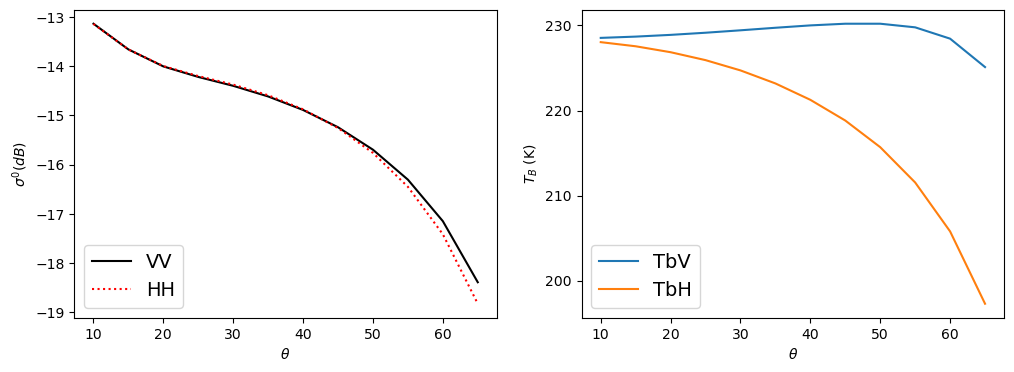

In [8]:
#lets do a plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12,4))
plt.rcParams.update({'font.size': 14})
ax1.ticklabel_format(axis='both', style='sci', scilimits=(0,2))
ax1.plot(theta, dB(res.sigmaVV()), 'k-',label = 'VV')
ax1.plot(theta, dB(res.sigmaHH()), 'r:',label = 'HH')
ax1.set_ylabel('$\sigma^0 (dB)$')
ax1.set_xlabel("$\\theta$")
ax1.legend(loc = 3)


ax2.plot(theta, res_p.TbV(), label = 'TbV')
ax2.plot(theta, res_p.TbH(), label = 'TbH')
ax2.set_ylabel('$T_B$ (K)')
ax2.set_xlabel('$\\theta$')
ax2.legend();

***
### Sensitivity study of snow parameters on $\sigma^0$

##### Reminder: Equation for SSA
#### Porod length from debye equation
$ \large l_c = \kappa \frac{4(1-\phi_i)}{\rho_i SSA} $
<br><br>
where the volume fraction is define as such $ \phi_i = \rho_s/\rho_i$.

In [9]:
from smrt.core.globalconstants import DENSITY_OF_ICE

def ssa_to_l(ssa, density):
    #converting SSA to correlation length
    f = density/DENSITY_OF_ICE
    l_d = 4 * (1-f)/(DENSITY_OF_ICE*ssa)
    return l_d

In [10]:
#set constant parameters for the study
thick = [0.5] 
ssa = 17
temperature = 268
density = 320

#add frozen soil
soil = make_soil('geometrical_optics', complex(2,0.005), temperature = 265, mean_square_slope = 0.011)

#set radiometer for SWE retrievals
radar_ku = sensor_list.active([5e9, 17.25e9], 45)
m = make_model("iba", "dort")


#sensitivity of depth
depth_array = np.linspace(10,401,10)/100
snowpack = [make_snowpack(thickness = [thick], microstructure_model = "exponential", density = density,
                          temperature = temperature, corr_length = ssa_to_l(ssa, density), substrate = soil) for thick in depth_array]

res_depth = m.run(radar_ku, snowpack)

#sensitivity of temperature
temp_array = np.linspace(260,280,10)
snowpack = [make_snowpack(thickness = thick, microstructure_model = "exponential", density = density,
                          temperature = [temp], corr_length = ssa_to_l(ssa, density), substrate = soil) for temp in temp_array]

res_temp = m.run(radar_ku, snowpack)

#sensitivity of density
density_array = np.linspace(200,400,10)
snowpack = [make_snowpack(thickness = thick, microstructure_model = "exponential", density = [density],
                          temperature = temperature, corr_length = ssa_to_l(ssa, density), substrate = soil) for density in density_array]

res_density = m.run(radar_ku, snowpack)

#sensitivity of  SSA
ssa_array = np.linspace(5,40,10)
snowpack = [make_snowpack(thickness = thick, microstructure_model = "exponential", density = density,
                          temperature = temperature, corr_length = ssa_to_l(ssa, density), substrate = soil) for ssa in ssa_array]

res_lc = m.run(radar_ku, snowpack)

to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised
to be optimised


SMRTError: The ice temperature must be lower or equal to 273.15K

### Plot the results

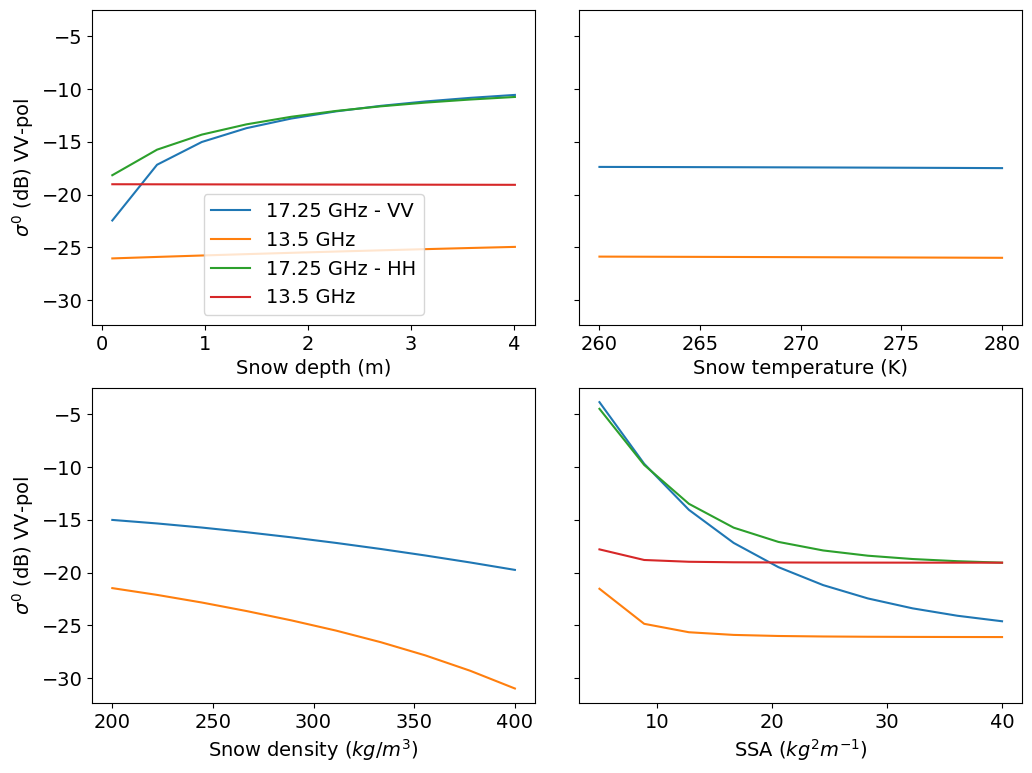

In [ ]:
#create a subfigure for each parameter studied
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12,9), sharey = True)
plt.rcParams.update({'font.size': 14})

#plot snow depth
ax1.plot(depth_array, dB(res_depth.sigmaVV().sel(frequency = 17.25e9)), label = '17.25 GHz - VV')
ax1.plot(depth_array, dB(res_depth.sigmaVV().sel(frequency = 5e9)), label = '13.5 GHz')
ax1.plot(depth_array, dB(res_depth.sigmaHH().sel(frequency = 17.25e9)), label = '17.25 GHz - HH')
ax1.plot(depth_array, dB(res_depth.sigmaHH().sel(frequency = 5e9)), label = '13.5 GHz')

ax1.set_xlabel('Snow depth (m)')
ax1.set_ylabel('$\sigma^0$ (dB) VV-pol')
ax1.legend()

#plot temperature
ax2.plot(temp_array, dB(res_temp.sigmaVV().sel(frequency = 17.25e9)).values)
ax2.plot(temp_array, dB(res_temp.sigmaVV().sel(frequency = 5e9)).values)
ax2.set_xlabel('Snow temperature (K)')

#plot density
ax3.plot(density_array, dB(res_density.sigmaVV().sel(frequency = 17.25e9)))
ax3.plot(density_array, dB(res_density.sigmaVV().sel(frequency = 5e9)))
ax3.set_xlabel('Snow density ($kg/m^3$)')
ax3.set_ylabel('$\sigma^0$ (dB) VV-pol')

#plot corr length
ax4.plot(ssa_array, dB(res_lc.sigmaVV().sel(frequency = 17.25e9)).values)
ax4.plot(ssa_array, dB(res_lc.sigmaVV().sel(frequency = 5e9)).values)
ax4.plot(ssa_array, dB(res_lc.sigmaHH().sel(frequency = 17.25e9)).values)
ax4.plot(ssa_array, dB(res_lc.sigmaHH().sel(frequency = 5e9)).values)
ax4.set_xlabel('SSA ($kg^2 m^{-1}$)')

plt.subplots_adjust(wspace = 0.1);


#####  SWE can be estimated empirically. However, the empirical relation might not hold for all snow types and conditions. This is where a radiative transfer can help to link backscatter and snow properties!!

### Add dimension to your result

#### Let's define multiple dimensions and use the full power of xarray and pandas

In [ ]:
#define a list of snowpack
depth_array = np.linspace(10,201,10)/100
ssa = 17
temperature = 268
density = 320
soil = make_soil('soil_wegmuller', complex(3,0.005), temperature = 265, roughness_rms = 0.017)
snowpack = [make_snowpack(thickness = [thick], microstructure_model = "exponential", density = density,
                          temperature = temperature, corr_length = ssa_to_l(ssa, density), substrate = soil) for thick in depth_array]

#sensor can have two frequency
#use the common AMSRE satellite
sensor = sensor_list.amsre(['19', '37'])

#define dimension of the list of snowpack
res_depth = m.run(sensor, snowpack, snowpack_dimension = ('depth', depth_array))
res_depth.Tb()

<xarray.DataArray (frequency: 2, depth: 10, polarization: 2)>
array([[[262.49151178, 246.45487683],
        [261.89004943, 245.65550538],
        [261.30836488, 244.89006237],
        [260.75424975, 244.16563263],
        [260.23073174, 243.48433271],
        [259.73884077, 242.84627265],
        [259.27852813, 242.25052799],
        [258.84911217, 241.69560023],
        [258.44952947, 241.1796705 ],
        [258.0784886 , 240.70075128]],

       [[258.36136207, 241.2841905 ],
        [248.90208474, 230.26046276],
        [242.22388597, 222.73837456],
        [237.83110105, 217.85848571],
        [235.02772756, 214.75957524],
        [233.26975903, 212.81653695],
        [232.18167469, 211.61040557],
        [231.51641762, 210.86914805],
        [231.11522687, 210.41888781],
        [230.877458  , 210.14950524]]])
Coordinates:
    theta         float64 55.0
  * polarization  (polarization) <U1 'V' 'H'
  * depth         (depth) float64 0.1 0.3122 0.5244 0.7367 ... 1.586 1.798 2.01
  * frequency     (frequency) float64 1.87e+10 3.65e+10
Attributes:
    mode:     P

In [ ]:

snowpack = pd.Series([make_snowpack(thickness = [thick], microstructure_model = "exponential", density = density,
                          temperature = temperature, corr_length = ssa_to_l(ssa, density), 
                          substrate = make_soil('soil_wegmuller', complex(3,0.005),
                                                 temperature = 265, roughness_rms = 0.017)) for thick in depth_array], index = depth_array)

#define dimension of the list of snowpack
res_depth = m.run(sensor, snowpack)
res_depth.Tb()

<xarray.DataArray (frequency: 2, snowpack: 10, polarization: 2)>
array([[[262.49151178, 246.45487683],
        [261.89004943, 245.65550538],
        [261.30836488, 244.89006237],
        [260.75424975, 244.16563263],
        [260.23073174, 243.48433271],
        [259.73884077, 242.84627265],
        [259.27852813, 242.25052799],
        [258.84911217, 241.69560023],
        [258.44952947, 241.1796705 ],
        [258.0784886 , 240.70075128]],

       [[258.36136207, 241.2841905 ],
        [248.90208474, 230.26046276],
        [242.22388597, 222.73837456],
        [237.83110105, 217.85848571],
        [235.02772756, 214.75957524],
        [233.26975903, 212.81653695],
        [232.18167469, 211.61040557],
        [231.51641762, 210.86914805],
        [231.11522687, 210.41888781],
        [230.877458  , 210.14950524]]])
Coordinates:
    theta         float64 55.0
  * polarization  (polarization) <U1 'V' 'H'
  * snowpack      (snowpack) float64 0.1 0.3122 0.5244 ... 1.586 1.798 2.01
  * frequency     (frequency) float64 1.87e+10 3.65e+10
Attributes:
    mode:     P

In [ ]:
#result can also be set to a dataframe
res_depth.to_dataframe()

,19H,19V,37H,37V
snowpack,,,,
0.100000,246.454877,262.491512,241.284190,258.361362
0.312222,245.655505,261.890049,230.260463,248.902085
0.524444,244.890062,261.308365,222.738375,242.223886
0.736667,244.165633,260.754250,217.858486,237.831101
0.948889,243.484333,260.230732,214.759575,235.027728
1.161111,242.846273,259.738841,212.816537,233.269759
1.373333,242.250528,259.278528,211.610406,232.181675
1.585556,241.695600,258.849112,210.869148,231.516418
1.797778,241.179670,258.449529,210.418888,231.115227


## Optionnal parameters

 rtsolver_options = {'error_handling':'nan'}
 <br><br>

In [14]:
ssa = 0.1
temperature = 268
density = 320

#add frozen soil
soil = make_soil('geometrical_optics', complex(2,0.005), temperature = 265, mean_square_slope = 0.01)

#set radiometer for SWE retrievals
radar_ku = sensor_list.active([13.5e9, 17.25e9], 45)
#m = make_model("iba", "dort")
m = make_model("iba", "dort", rtsolver_options = {'error_handling':'nan'})


#sensitivity of depth
depth_array = np.linspace(10,401,10)/100
snowpack = [make_snowpack(thickness = [thick], microstructure_model = "exponential", density = density,
                          temperature = temperature, corr_length = ssa_to_l(ssa, density), substrate = soil) for thick in depth_array]


res_temp = m.run(radar_ku, snowpack)

to be optimised
norm= [2.09636136 2.09627338 2.14910513 2.14880009 2.18451077 2.1841561
 2.1988166  2.19852157 2.20423967 2.20401323 2.20627761 2.20610253
 2.20645513 2.20630951 2.204726   2.20458412 2.20049132 2.20032232
 2.19311687 2.1928855  2.18220018 2.18186946 2.16766455 2.16719914
 2.1497408  2.14910995 2.12889225 2.12807179 2.10572404 2.10469728
 2.08090084 2.07965857 2.05508391 2.05362369 2.02888909 2.02721424
 2.00286323 2.00098161 1.97747437 1.97539724 1.95311148 1.95085249
 1.93008995 1.92766424 1.90865998 1.90608357 1.88901628 1.88630549
 1.87130754 1.8684787  1.85564527 1.85271445 1.84211156 1.83909447
 1.83076564 1.82767752 1.82164928 1.81850495 1.81479106 1.81160495
 1.8102097  1.80699593 1.80791641 1.80468886 2.09636136 2.09627338
 2.14910513 2.14880009 2.18451077 2.1841561  2.1988166  2.19852157
 2.20423967 2.20401323 2.20627761 2.20610253 2.20645513 2.20630951
 2.204726   2.20458412 2.20049132 2.20032232 2.19311687 2.1928855
 2.18220018 2.18186946 2.16766455 2.167199

In [15]:
res_temp.sigmaVV()

<xarray.DataArray (frequency: 2, snowpack: 10)>
array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])
Coordinates:
    theta_inc  float64 45.0
  * snowpack   (snowpack) int64 0 1 2 3 4 5 6 7 8 9
  * frequency  (frequency) float64 1.35e+10 1.725e+10

### Parallel computation

#### advantage of running a multiple snowpack
The model can be run on a list of snowpacks or even more conveniently on a pandas.Series or pandas.DataFrame including snowpacks. The first advantage is that by setting parallel_computation=True, the Model.run() method performs the simulation in parallel on all the available cores of your machine and even possibly on a high performance cluster using dask. The second advantage is that the returned Result object contains all the simulations and provide an easier way to plot the results or compute statistics.

The job lib library is used to compute in parallel multiple snowpack <br>
*** needs a list of snowpack when calling run

In [16]:
res_temp = m.run(radar_ku, snowpack, parallel_computation=True)

### Some wise words from Ghislain Picard (developper)
Question from user: <br>
Do you have any plans to convert this code into C++ ?

There is not plan to convert to a different language. SMRT is fast despite being written in Python. The computational bottleneck is often in the diagonalisation of matrices, which is handled very efficiently with underlying LAPACK. A Fortran / C++ code would be marginally faster.

### Exemple with real data (CROCUS)

In [17]:
import xarray as xr
from datetime import datetime

In [18]:
mod = xr.open_dataset('data/Pow_out_svs2.nc')

df = mod[['SNODEN_ML','SNOMA_ML','TSNOW_ML','SNODOPT_ML','SNODP']].to_dataframe().dropna() 
# SNODEN_ML: Layer density 
# SNOMA_ML: Layer SWE
# TSNOW_ML: Layer temperature
# SNODOPT_ML: Layer optical diameter
# SNODP: depth of the snowpack

##### Recall optical diameter
$ \large D_{0} = \frac{6}{SSA \rho_i} $

In [19]:
def Do_to_ssa(Do):
    return 6/( Do * 917)

#add colums for SMRT

#thickness
df['thickness'] = df[['SNODEN_ML','SNOMA_ML']].apply(lambda x : x[1] / x[0], axis = 1) 

#SSA
df['ssa'] = df['SNODOPT_ML'].apply(lambda x: Do_to_ssa(x) if x>0 else 0)
#df['corr_length'] = df[['SNODEN_ML','ssa']].apply(lambda x: debye_eqn(x[1], x[0]), axis = 1)

In [20]:
#filter out low snowdepth and small snow layers
df = df[(df.SNODP > 0.10) & (df.thickness > 0.005)]
df

SNODEN_ML   SNOMA_ML  TSNOW_ML  SNODOPT_ML  \
time                snow_layer                                               
2022-12-27 12:00:00 0            51.74858   0.548978  250.1576    0.000101   
                    1            51.00084   0.562405  252.6715    0.000108   
                    2            65.13754   0.615617  255.1229    0.000184   
                    3            76.51376   0.685301  257.4022    0.000249   
                    4           111.91330   1.192564  259.9209    0.000319   
...                                   ...        ...       ...         ...   
2023-04-11 12:00:00 2           834.73140  50.521060  272.5916    0.000744   
                    3           916.99990  40.212150  272.5978    0.000623   
2023-04-11 18:00:00 0           889.31710  12.455170  273.1600    0.000644   
                    1           840.82060  48.542820  273.1600    0.000748   
                    2           916.99990  40.153860  273.1600    0.000634   

                                   SNODP  thickness        ssa  
time                snow_layer                                  
2022-12-27 12:00:00 0           0.105732   0.010609  65.041350  
                    1           0.105732   0.011027  60.834013  
                    2           0.105732   0.009451  35.568001  
                    3           0.105732   0.008957  26.259556  
                    4           0.105732   0.010656  20.487426  
...                                  ...        ...        ...  
2023-04-11 12:00:00 2           0.139042   0.060524   8.797306  
                    3           0.139042   0.043852  10.505392  
2023-04-11 18:00:00 0           0.115526   0.014005  10.167052  
                    1           0.115526   0.057733   8.748877  
                    2           0.115526   0.043788  10.312315  

[3889 rows x 7 columns]

In [30]:
#get dates
dates = df.groupby(level = 'time').mean().index.get_level_values(0)
df.loc[dates[0],:]
df = df[df.TSNOW_ML <273.15]

In [31]:
def get_snowpack(snow_df):
    #add frozen soil
    soil = make_soil('geometrical_optics', complex(2,0.005), temperature = 265, mean_square_slope = 0.01)

    #Creating the snowpack to simulate with the substrate
    if isinstance(snow_df.thickness, np.floating):
        thickness = [snow_df.thickness]
    else:
        thickness = snow_df.thickness
        
    sp = make_snowpack(thickness=thickness, 
                        microstructure_model='exponential',
                        density= snow_df.SNODEN_ML,
                        temperature= snow_df.TSNOW_ML,
                        corr_length = ssa_to_l(snow_df.ssa, snow_df.SNODEN_ML),
                        substrate = soil)
    
    return sp

In [33]:
#get dates
dates = df.groupby(level = 'time').mean().index.get_level_values(0)#
#get total SWE per date
SWE = df.groupby(level = 'time').sum().SNOMA_ML
#get total snowdepth per date
depth = df.groupby(level = 'time').mean().SNODP

#create a series of snowpack object
snowpacks = pd.Series([get_snowpack(df.loc[date,:]) for date in dates ], index = dates)

#create a dataframe
meta_df = pd.DataFrame({'depth' :depth, 'SWE': SWE, 'smrt_snow' : snowpacks}, index = dates).dropna()
meta_df

,depth,SWE,smrt_snow
time,,,
2022-12-27 12:00:00,0.105732,11.333826,Snowpack: layer ...
2022-12-27 18:00:00,0.107803,11.479237,Snowpack: layer ...
2022-12-28 00:00:00,0.112218,11.912895,Snowpack: layer ...
2022-12-28 06:00:00,0.130744,13.787896,Snowpack: layer ...
2022-12-28 12:00:00,0.195925,20.856456,Snowpack: layer ...
...,...,...,...
2023-04-09 18:00:00,0.211536,89.193290,Snowpack: layer ...
2023-04-10 06:00:00,0.193669,156.052240,Snowpack: layer ...
2023-04-10 12:00:00,0.193563,156.010970,Snowpack: layer ...


In [34]:
#Modeling theories to use in SMRT
model = make_model("symsce_torquato21", "dort", rtsolver_options = {'error_handling':'nan'})

sensor  = sensor_list.active(17.5e9, 35)

result = model.run(sensor, meta_df, snowpack_column='smrt_snow', parallel_computation=True)


In [51]:
dB(result.data.values[::-1][0])

array([[[ -24.75285205,           nan,  -29.35167848],
        [          nan,  -24.58245414,           nan],
        [-182.89096736,           nan, -183.05749042]]])

In [35]:
meta_df['sigVV'] = dB(result.sigmaVV())
meta_df['sigHH'] = dB(result.sigmaHH())

In [36]:
meta_df.head()

,depth,SWE,smrt_snow,sigVV,sigHH
time,,,,,
2022-12-27 12:00:00,0.105732,11.333826,Snowpack: layer ...,-14.867214,-10.517257
2022-12-27 18:00:00,0.107803,11.479237,Snowpack: layer ...,-14.830011,-10.520584
2022-12-28 00:00:00,0.112218,11.912895,Snowpack: layer ...,-14.815732,-10.534407
2022-12-28 06:00:00,0.130744,13.787896,Snowpack: layer ...,-14.776394,-10.548357
2022-12-28 12:00:00,0.195925,20.856456,Snowpack: layer ...,-14.737387,-10.559758


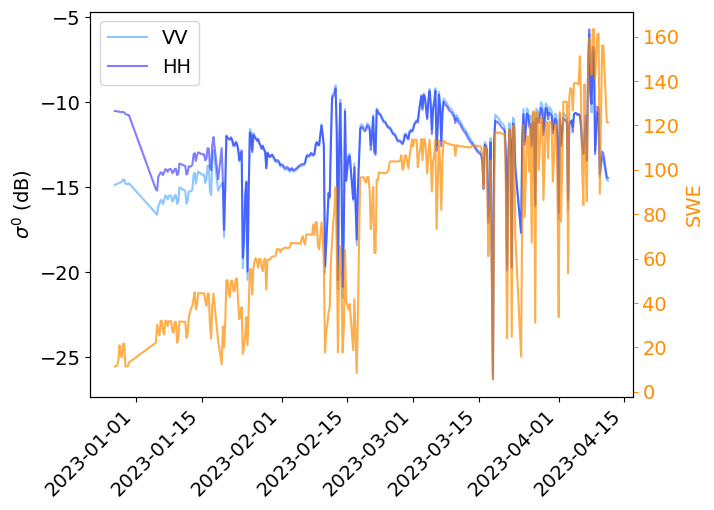

In [37]:
fig, ax = plt.subplots(1,1, figsize = (7,5))
ax.plot(meta_df.index, meta_df.sigVV, color = 'dodgerblue',label = 'VV', alpha = 0.5)
ax.plot(meta_df.index, meta_df.sigHH, color = 'blue', label = 'HH', alpha = 0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend()
ax.set_ylabel('$\sigma^0$ (dB)')

ax2=ax.twinx()
ax2.plot(meta_df.index, meta_df.SWE, color = 'darkorange', alpha = 0.7)
ax2.set_ylabel('SWE')
ax2.yaxis.label.set_color('darkorange')
ax2.tick_params(axis='y', colors='darkorange');

## (Advanced) Different flavours of SMRT

 The SMRT model was developed in response to increased understanding of the importance of microstructure parameterization in snow, and to enable isolation of individual model components in microwave scattering model intercomparison studies. For this, SMRT has a modular structure, which clearly separates the different steps of the calculation (permittivities of the raw materials, scattering coefficients, and solution of the radiative transfer (RT) equation) (Sandells et al. 2022)

### Electromagnetic Models 
- DMRT (Dense media)
- IBA (Improved Born Approximation)
- symSCE (symmetrized Strong Constrast Expansion)

### Microstrure models (autocorrelation function of ice/air matrix which change calculation of $k_s$)


In [38]:

#define function to get microstructure parameters from ssa
def ssa_to_R(ssa, density):
    #converting SSA to eq radius
    return 3/(DENSITY_OF_ICE*ssa)


In [39]:
#start from SSA, which you would get from field measurements
ssa_array = np.arange(10, 65, 5)

#set other parameters for the study
#thick must be a list or array to infer number of layer
thick = [0.5] 
temperature = 268 
density = 320

#add frozen soil
soil = make_soil('soil_wegmuller', complex(3.34,0.005), temperature = 265, roughness_rms = 0.017)

In [40]:
#create sensor for amsre channel
radio  = sensor_list.amsre('37')

#set electromagnetic model
#iba can run most of the microstructure model
m_iba = make_model("iba", "dort")
#DMRT only can run SHS
m_dmrt = make_model('dmrt_qca_shortrange', 'dort')
#SCE strong contrast expansion (new model for high density)
m_sce = make_model("sce_torquato21", "dort")

#set snowpack with different microstructure model
#Microstructure exponential
snowpack_exp = [make_snowpack(thickness = thick, microstructure_model = "exponential", density = density,
                          temperature = temperature, corr_length = [ssa_to_l(ssa, density)], substrate = soil) for ssa in ssa_array]
#Microstructure IND
snowpack_ind = [make_snowpack(thickness = thick, microstructure_model = "independent_sphere", density = density,
                          temperature = temperature, radius = [ssa_to_R(ssa, density)], substrate = soil) for ssa in ssa_array]
#Microstructure SHS
snowpack_shs = [make_snowpack(thickness = thick, microstructure_model = "sticky_hard_spheres", density = density,
                          temperature = temperature, radius = [ssa_to_R(ssa, density)], stickiness = 0.3, substrate = soil) for ssa in ssa_array]

#run result for iba EXP
res_iba_exp = m_iba.run(radio, snowpack_exp, snowpack_dimension = ('ssa', ssa_array))

#run result for iba IND
res_iba_ind = m_iba.run(radio, snowpack_ind, snowpack_dimension = ('ssa', ssa_array))

#run result for iba SHS
res_iba_shs = m_iba.run(radio, snowpack_shs, snowpack_dimension = ('ssa', ssa_array))

#run result for DMRT SHS
res_dmrt_shs = m_dmrt.run(radio, snowpack_shs, snowpack_dimension = ('ssa', ssa_array))

#run result for sce EXP
res_sce_exp = m_sce.run(radio, snowpack_exp, snowpack_dimension = ('ssa', ssa_array))

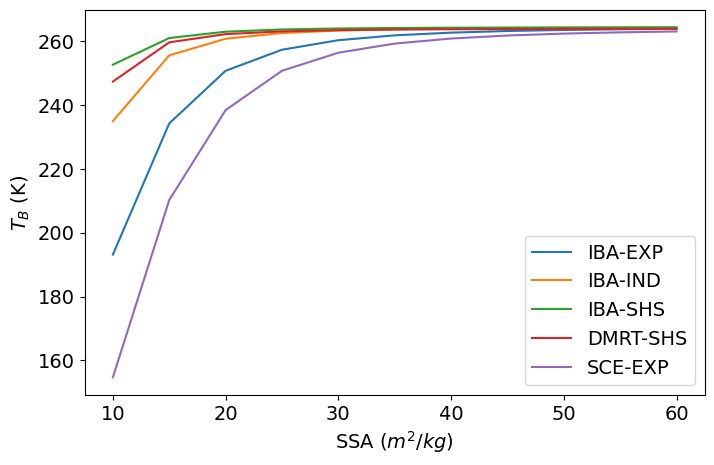

In [41]:
#create a subfigure for each parameter studied
fig = plt.figure(figsize = (8,5))
plt.rcParams.update({'font.size': 14})

#plot the results
plt.plot(res_iba_exp.ssa, res_iba_exp.TbV(), label = 'IBA-EXP')
plt.plot(res_iba_ind.ssa, res_iba_ind.TbV(), label = 'IBA-IND')
plt.plot(res_iba_shs.ssa, res_iba_shs.TbV(), label = 'IBA-SHS')
plt.plot(res_dmrt_shs.ssa, res_dmrt_shs.TbV(), label = 'DMRT-SHS')
plt.plot(res_sce_exp.ssa, res_sce_exp.TbV(), label = 'SCE-EXP')
plt.xlabel('SSA ($m^2/kg)$')
plt.ylabel('$T_B$ (K)')
plt.legend();

#### The choice of the microstructure and electromagnetic model does have an impact, especially for low SSA in this case.
***

## Conclusion


- Allows you to simulate measurements of snow or ice from radiometer and RADAR.
- Comparaison between models components (electromagnetic, microstructure, ...) and unified radiative transfer modelling into one models.
- Easy to use with python!

ECCC focus:
- allows us to estimate SWE from backscatter of dual Ku-band by using snow properties from SVS2



#### For more exercices... see the tutorials on the github page

### More info

- Documentation : 
https://smrt-model.science/documentation.html

- Github page : 
https://github.com/smrt-model

- Reference paper : 
https://gmd.copernicus.org/articles/11/2763/2018/gmd-11-2763-2018.html

***